In [1]:
import pandas as pd
import ixmp4
import pyam
import nomenclature

In [2]:
iamc_args = dict(
    model="State of CDR (2024) - Research and Development",
    scenario="Observed Data",
)

In [9]:
df_publications = pyam.IamDataFrame(
    (
        pd.read_excel("source/2_Research_Development/SoCDRv2_Scientific_Publications.xlsx")
        .drop(columns=["Unnamed: 0", "description"])
    ),
    **iamc_args,
).rename(region={"USA + CA": "North America"})

df_publications.rename(
    variable=dict(
        [(i, i.replace("Research|", "Research|Removal|")) for i in df_publications.variable]
    ), 
    inplace=True,
)

In [11]:
groupby = df_publications.timeseries().groupby(
    ["model", "scenario", "region"]
)

for i, _data in groupby:
    failing = _data.sum().between(0.1, 0.99)
    if any(failing):
        print(i)
        print(_data.columns[failing])

In [28]:
data = (
    pd.read_excel("source/2_Research_Development/chapter-2-template_BP_v2.xlsx", sheet_name="variable")
    .drop(columns="description")
)

df_patents = pyam.IamDataFrame(
    data,
    **iamc_args,
).filter(variable="Research|Patents*")

df_patents.rename(
    variable=dict(
        [(i, (
            i.replace("Research|Patents|Carbon Dioxide Removal", "Research|Removal|Patents")
            .replace("Research|Patents|Climate Change Mitigation", "Research|Mitigation|Patents")        
        )) for i in df_patents.variable]
    ), 
    inplace=True,
)

In [33]:
data = (
    pd.read_excel("source/2_Research_Development/chapter-2_grants_formatted+funding.xlsx")
    .drop(columns="description")
)

df_grants_funding = pyam.IamDataFrame(
    data,
    **iamc_args,
)

df_grants_funding.rename(
    variable=dict(
        [(i, i.replace("Research|", "Research|Removal|")) for i in df_grants_funding.variable]
    ), 
    inplace=True,
)

# Merge data

In [96]:
df = pyam.concat([df_patents, df_publications, df_grants_funding])

In [97]:
mapping = dict(
    [(i, i.replace("[share per year]", " [Share]")) for i in df.variable]
)
df.rename(variable=mapping, inplace=True)

In [98]:
mapping = dict(
    [(i, i.replace("[share per year and region]", " [Share]")) for i in df.variable]
)
df.rename(variable=mapping, inplace=True)

In [99]:
mapping = dict(
    [(i, (
        i.replace("AR", "Afforestation and Reforestation")
        .replace("BECCS", "Bioenergy with CCS")
        .replace("DAC(CS)", "Direct Air Capture with CCS")
        .replace("Restoration of Landscapes and Peats", "Peatland and Wetland Restoration")
        .replace("Ocean alkalinity enhancement", "Ocean Alkalinity Enhancement")
        .replace("Forest Management", "Improved Forest Management")
        .replace("Ocean alkalinity enhancement", "Ocean Alkalinity Enhancement")
        .replace("Ocean fertilization & Artificial upwelling", "Ocean Fertilization")
        .replace("Restoration of landscapes/peats", "Restoration of Landscapes and Peats")
        .replace("Enhanced Weathering (land based)", "Enhanced Weathering")
        .replace(" Literature on CDR/NET", "")
    )) for i in df.variable]
)
df.rename(variable=mapping, inplace=True)

In [102]:
mapping = dict(
    [
        (i, i.replace("Restoration of Landscapes and Peats", "Peatland and Wetland Restoration"))
        for i in df.variable]
)
df.rename(variable=mapping, inplace=True)

In [103]:
dsd = nomenclature.DataStructureDefinition("../definitions/")

In [104]:
dsd.validate(df)

In [105]:
df.filter(variable="*Share*").timeseries()

2000  \
model                                          scenario      region variable                                           unit             
State of CDR (2024) - Research and Development Observed Data Africa Research|Removal|Publications|Afforestation and... %     0.000000   
                                                                    Research|Removal|Publications|Biochar [Share]      %     0.000000   
                                                                    Research|Removal|Publications|Bioenergy with CC... %     0.000000   
                                                                    Research|Removal|Publications|Blue Carbon [Share]  %     0.000000   
                                                                    Research|Removal|Publications|Direct Air Captur... %     0.000000   
...                                                                                                                               ...   
                                                             World  Research|Removal|Publications|General [Share]      %     0.010753   
                                                                    Research|Removal|Publications|Ocean Alkalinity ... %     0.000000   
                                                                    Research|Removal|Publications|Ocean Fertilizati... %     0.075269   
                                                                    Research|Removal|Publications|Peatland and Wetl... %     0.053763   
                                                                    Research|Removal|Publications|Soil Carbon Seque... %     0.333333   

                                                                                                                                 2001  \
model                                          scenario      region variable                                           unit             
State of CDR (2024) - Research and Development Observed Data Africa Research|Removal|Publications|Afforestation and... %     0.000000   
                                                                    Research|Removal|Publications|Biochar [Share]      %     0.000000   
                                                                    Research|Removal|Publications|Bioenergy with CC... %     0.000000   
                                                                    Research|Removal|Publications|Blue Carbon [Share]  %     0.000000   
                                                                    Research|Removal|Publications|Direct Air Captur... %     0.000000   
...                                                                                                                               ...   
                                                             World  Research|Removal|Publications|General [Share]      %     0.025316   
                                                                    Research|Removal|Publications|Ocean Alkalinity ... %     0.000000   
                                                                    Research|Removal|Publications|Ocean Fertilizati... %     0.126582   
                                                                    Research|Removal|Publications|Peatland and Wetl... %     0.126582   
                                                                    Research|Removal|Publications|Soil Carbon Seque... %     0.265823   

                                                                                                                              2002  \
model                                          scenario      region variable                                           unit          
State of CDR (2024) - Research and Development Observed Data Africa Research|Removal|Publications|Afforestation and... %     0.000   
                                                                    Research|Removal|Publications|Biochar [Share]      %     1.000   
                             

In [106]:
shares_df = df.filter(variable="* [Share]")
shares_df._data = shares_df._data * 100

df = pyam.concat([df.filter(variable="* [Share]", keep=False), shares_df])

In [107]:
groupby = df.filter(variable="* [Share]").timeseries().groupby(
    ["model", "scenario", "region"]
)

for i, _data in groupby:
    failing = _data.sum().between(0.1, 95)
    if any(failing):
        print(i)
        print(_data.columns[failing])

In [113]:
df.filter(variable="*Mitigation*").variable

['Research|Mitigation|Patents [relative to 2020]']

In [112]:
[v for v in dsd.variable if v not in df.variable and v.startswith("Research")]

['Research|Mitigation|Patents',
 'Research|Removal|Active Grants|Bio-Oil Storage',
 'Research|Removal|Active Grants|Mineral Products',
 'Research|Removal|Active Grants|Biomass Burial',
 'Research|Removal|Active Grants|Biomass Sinking',
 'Research|Removal|Active Grants|Direct Ocean Capture',
 'Research|Removal|Active Grants|Forestry',
 'Research|Removal|Active Grants|Agroforestry',
 'Research|Removal|Active Grants|Improved Forest Management',
 'Research|Removal|Active Grants|Durable Wood Products',
 'Research|Removal|Funding|Bio-Oil Storage',
 'Research|Removal|Funding|Mineral Products',
 'Research|Removal|Funding|Biomass Burial',
 'Research|Removal|Funding|Biomass Sinking',
 'Research|Removal|Funding|Direct Ocean Capture',
 'Research|Removal|Funding|Forestry',
 'Research|Removal|Funding|Agroforestry',
 'Research|Removal|Funding|Improved Forest Management',
 'Research|Removal|Funding|Durable Wood Products',
 'Research|Removal|Publications|Bio-Oil Storage',
 'Research|Removal|Publication

In [ ]:
data = run.iamc.tabulate()

In [ ]:
run.iamc.remove(data)

In [ ]:
run.iamc.add(df.data)

In [ ]:
#df.to_ixmp4("socdr-dev")

In [124]:
df.to_excel("socdr-chapter-2-data_v3.xlsx")

In [115]:
import ixmp4

In [116]:
platform = ixmp4.Platform("socdr-dev")

2024-05-15 15:44:28 INFO     HTTP Request: POST https://api.manager.ece.iiasa.ac.at/v1/token/obtain/ "HTTP/1.1 200 OK"
[INFO] 15:44:28 - ixmp4.conf.settings: Connecting as user 'huppmann'.
2024-05-15 15:44:28 INFO     Connecting as user 'huppmann'.
2024-05-15 15:44:29 INFO     HTTP Request: POST https://api.manager.ece.iiasa.ac.at/v1/token/obtain/ "HTTP/1.1 200 OK"
2024-05-15 15:44:29 INFO     HTTP Request: GET https://api.manager.ece.iiasa.ac.at/v1/ixmp4?page_size=-1 "HTTP/1.1 200 OK"
2024-05-15 15:44:29 INFO     HTTP Request: GET https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/ "HTTP/1.1 200 OK"
[INFO] 15:44:29 - ixmp4.data.backend.api: Connected to IXMP4 Platform 'socdr-dev'
2024-05-15 15:44:29 INFO     Connected to IXMP4 Platform 'socdr-dev'
[WARNING] 15:44:29 - ixmp4.data.backend.api: IXMP4 Client and Server versions do not match. (Client: 0.0.0, Server: 0.8.0)
2024-05-15 15:44:29 WARNING  IXMP4 Client and Server versions do not match. (Client: 0.0.0, Server: 0.8.0)
[INFO] 15:44:29 - ix

In [125]:
run = platform.runs.create(**iamc_args)

2024-05-15 15:47:10 INFO     HTTP Request: POST https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/runs/ "HTTP/1.1 200 OK"
2024-05-15 15:47:10 INFO     HTTP Request: PATCH https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/meta/?table=true "HTTP/1.1 200 OK"


In [126]:
run.set_as_default()

2024-05-15 15:47:19 INFO     HTTP Request: POST https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/runs/18/set-as-default-version/ "HTTP/1.1 200 OK"


In [128]:
run.meta["Chapter"] = "Chapter 2"

2024-05-15 15:48:02 INFO     HTTP Request: POST https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/meta/ "HTTP/1.1 200 OK"
2024-05-15 15:48:02 INFO     HTTP Request: PATCH https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/meta/?table=true "HTTP/1.1 200 OK"


In [129]:
run.iamc.add(df.data)

2024-05-15 15:48:11 INFO     HTTP Request: POST https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/iamc/timeseries/bulk/?create_related=true "HTTP/1.1 201 Created"
2024-05-15 15:48:11 INFO     HTTP Request: PATCH https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/iamc/timeseries/?join_parameters=true&table=true "HTTP/1.1 200 OK"
2024-05-15 15:48:13 INFO     HTTP Request: POST https://ixmp.ece.iiasa.ac.at/v1/socdr-dev/iamc/datapoints/bulk/ "HTTP/1.1 200 OK"


<Axes: title={'center': 'model: State of CDR (2024) - Research and Development - scenario: Observed Data - region: World - variable: Research|Mitigation|Patents [relative to 2020]'}, xlabel='Year', ylabel='Value'>

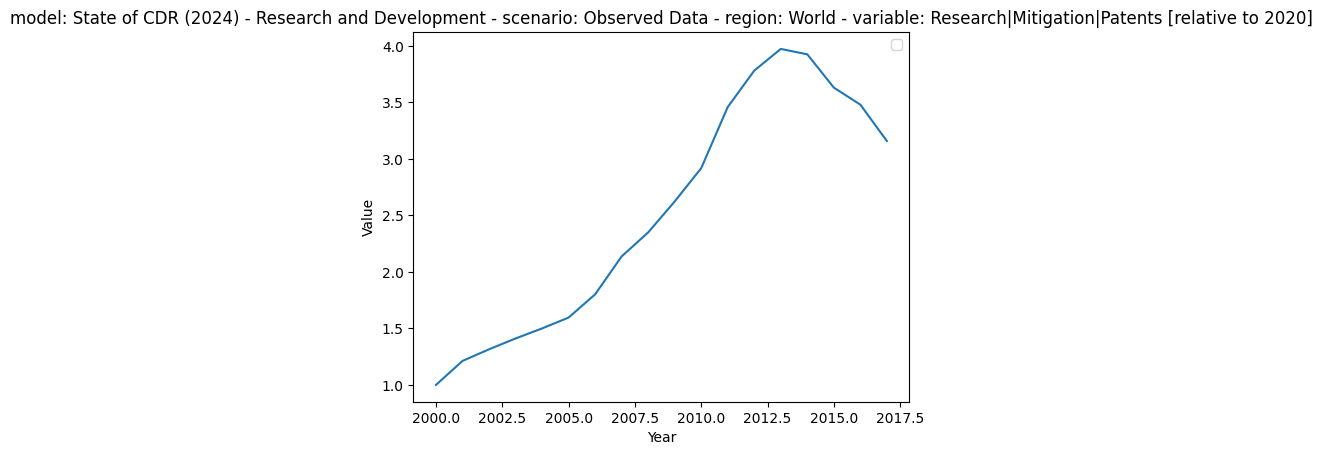

In [157]:
df.filter(variable="Research|Mitigation|*").plot()